# Data download

In [1]:
! curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
! curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
! curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
! curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
    
! gunzip ./*.gz

# Data inspection

In [2]:
import numpy as np
from mnist import MNIST
import matplotlib.pyplot as plt

#### Load the data and cast lists as numpy array objects for faster processing.

In [3]:
mndata = MNIST('./')

images, labels = mndata.load_training()
images = np.array(images)
labels = np.array(labels.tolist())

images_test, labels_test = mndata.load_testing()
images_test = np.array(images_test)
labels_test = np.array(labels_test.tolist())

#### Validate number of images and labels in training and validation (test) data, as well as length of vectorized first image array in training and validation datasets.

In [4]:
print(len(images), len(labels))
print(len(images_test), len(labels_test))

print(len(images[0]))
print(len(images_test[0]))

60000 60000
10000 10000
784
784


#### Plot first instance of each digit type in training dataset.

In [5]:
# ! mkdir plots

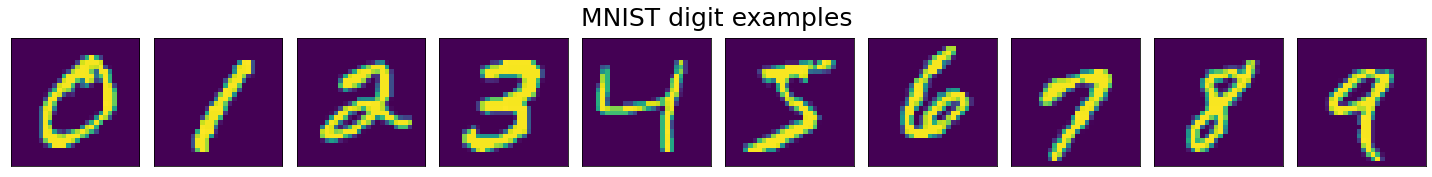

In [6]:
plt.figure(figsize=(20, 5))

rows = 1
columns = 10

for i in range(rows*columns):
    ax = plt.subplot(rows, columns, i + 1)
    for j,v in enumerate(images):
        if labels[j] == i:
            image = np.array(v).reshape(28,28)
            ax.imshow(image)
            ax.set_xticks(())
            ax.set_yticks(())
            break

plt.suptitle('MNIST digit examples', fontsize=25)
plt.tight_layout()
plt.subplots_adjust(top=1.4)
# plt.savefig('plots/digits.png')

#### Examine variability of hand-written 5 digits.

In [7]:
fives = []
integer = 5
for i,v in enumerate(labels):
    if v == integer:
        fives.append(images[i])

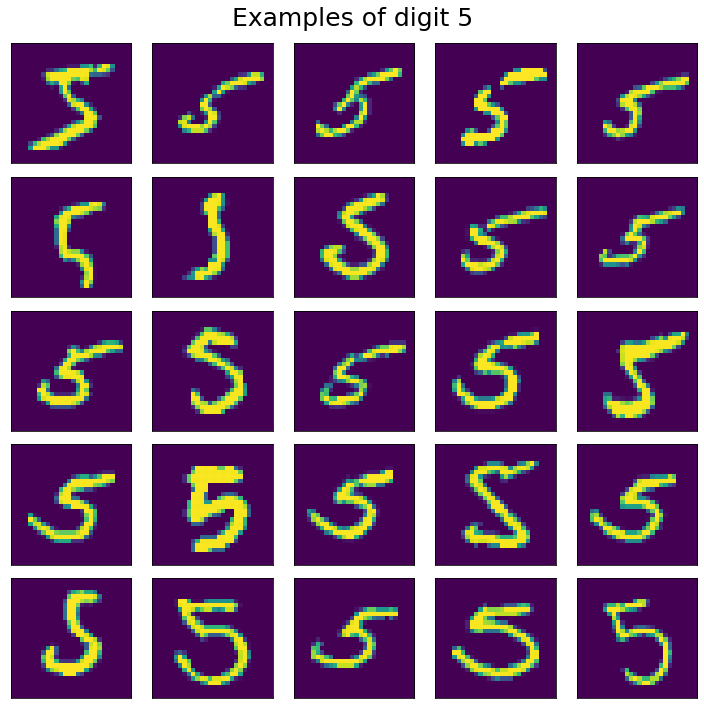

In [8]:
plt.figure(figsize=(10, 10))

rows = 5
columns = 5

for i in range(rows*columns):
    ax = plt.subplot(rows, columns, i + 1)
    image = np.array(fives[i]).reshape(28,28)
    ax.imshow(image)
    ax.set_xticks(())
    ax.set_yticks(())
    
plt.suptitle('Examples of digit 5', fontsize=25)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
# plt.savefig('plots/fives.png')

# Logistic Regression Model Fitting

## NumPy solution

In [9]:
import numpy as np

import warnings
warnings.filterwarnings('ignore')

#### Create boolean arrays for each integer type.

In [10]:
def bool_array(B):
    y = []

    for i in range(10):
        array = []
        for index, value in enumerate(B):
            if value == i:
                array.append(1)
            else:
                array.append(0)


        y.append(array)
        
    y = np.array(y)
    
    return y

In [11]:
y = bool_array(labels)
y_test = bool_array(labels_test)

In [12]:
X = images
X_test = images_test

#### Build model.

In [13]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [14]:
def loss(h, y):
    return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

In [15]:
def fit(X, y, num_iter=100, loss_rate=0.01):
    intercept = np.ones((X.shape[0], 1))
    X = np.concatenate((intercept, X), axis=1)
    theta = np.zeros(X.shape[1])
    for i in range(num_iter):
        z = np.dot(X, theta)
        h = sigmoid(z)
        gradient = np.dot(X.T, (h - y)) / y.size
        theta -= loss_rate * gradient    
    return theta

In [16]:
def predict_prob(X, theta, B_validation, threshold=0.5):
    intercept = np.ones((X.shape[0], 1))
    X = np.concatenate((intercept, X), axis=1)
    B = sigmoid(np.dot(X, theta))
    B = B >= threshold
    return B

In [17]:
def build_model(X, y, num_iter=100, loss_rate=0.01):
    coefficients = []
    for i, v in enumerate(y):
        theta = fit(X, v, num_iter=num_iter, loss_rate=loss_rate)
        coefficients.append(theta)
    return np.array(coefficients)

In [18]:
def validate_model(coefficients, X_test, y_test):
    B = []
    scores = []
    for i, v in enumerate(y_test):
        Bn = predict_prob(X_test, coefficients[i], v)
        score = (Bn == v).mean()
        scores.append(score)
        B.append(Bn)
        
    scores = np.array(scores)
    
    return np.array(B), scores.mean(), scores

In [19]:
%time coefficients = build_model(X, y, num_iter=100, loss_rate=0.01)

CPU times: user 5min 10s, sys: 4.06 s, total: 5min 14s
Wall time: 41.5 s


In [20]:
sparsity = np.mean(np.array(coefficients) == 0) * 100
predictions, score, scores = validate_model(coefficients, X_test, y_test)

In [21]:
sparsity

8.535031847133757

In [22]:
score

0.96136

#### Plot diagonal of confusion matrix.

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [24]:
cm = np.zeros((10,10))
np.fill_diagonal(cm, scores)

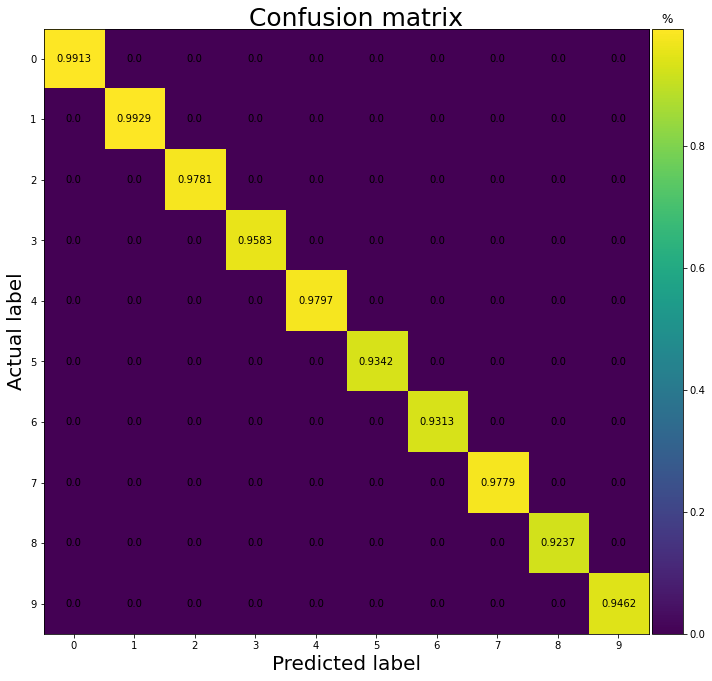

In [25]:
fig, ax = plt.subplots(figsize=(10,10))

tick_marks = np.arange(10)
plt.xlabel('Predicted label',fontsize=20)
plt.ylabel('Actual label',fontsize=20)
plt.xticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], size = 10)
plt.yticks(tick_marks, ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], size = 10)


im = plt.imshow(cm, interpolation='nearest', cmap='viridis')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im, cax=cax)
clb.ax.set_title('%')

plt.suptitle('Confusion matrix', fontsize=25)
plt.tight_layout()
plt.subplots_adjust(top=1)

width, height = cm.shape
for x in range(width):
    for y in range(height):
        ax.annotate(str(cm[x][y]), xy=(y, x), 
                     horizontalalignment='center',
                     verticalalignment='center')

# plt.savefig('plots/np_confusion_matrix.png')

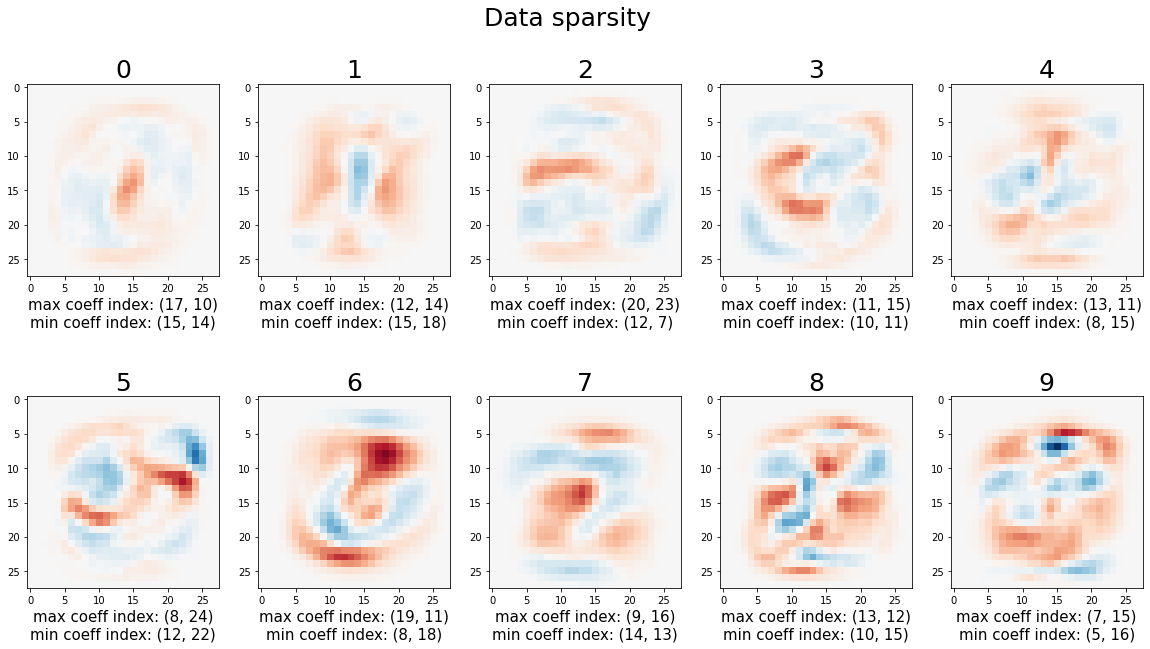

In [26]:
scale = np.abs(coefficients).max()

plt.figure(figsize=(20, 10))

for i in range(len(coefficients)):
    image = coefficients[i][1:].reshape(28, 28).copy()
    
    ax = plt.subplot(2, 5, i + 1)
    ax.imshow(image, 
              interpolation='nearest',
              cmap='RdBu', 
              vmin=-scale, 
              vmax=scale)
    
    max_coeff_index = str(np.unravel_index(image.argmax(), image.shape)) 
    min_coeff_index = str(np.unravel_index(image.argmin(), image.shape)) 
    
    ax.set_title(str(i),fontsize=25)
    
    text = 'max coeff index: ' + max_coeff_index + '\nmin coeff index: ' + min_coeff_index
    ax.set_xlabel(text,fontsize=15)
    
plt.suptitle('Data sparsity', fontsize=25)
plt.subplots_adjust(top=0.92)
# plt.savefig('plots/np_sparsity.png')

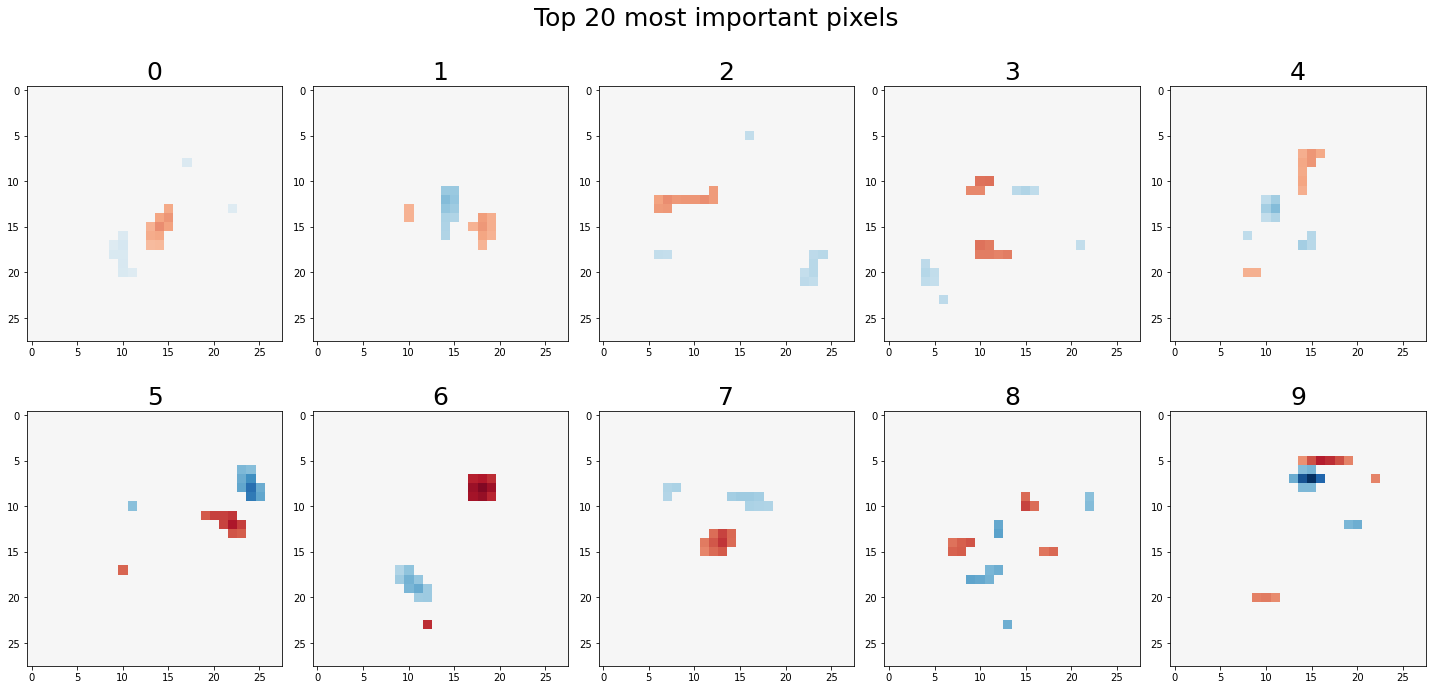

In [27]:
scale = np.abs(coefficients).max()

plt.figure(figsize=(20, 10))

for i in range(len(coefficients)):
    
    img = np.zeros((28,28))
    image = coefficients[i][1:].reshape(28, 28).copy()
    
    for j in range(10):
        max_idx = np.unravel_index(image.argmax(), image.shape)
        min_idx = np.unravel_index(image.argmin(), image.shape)
        
        val = image[max_idx]
        img[max_idx] = val
        image[max_idx] = 0
        
        val = image[min_idx]
        img[min_idx] = val
        image[min_idx] = 0
    
    ax = plt.subplot(2, 5, i + 1)
    ax.imshow(img, 
              interpolation='none',
              cmap='RdBu', 
              vmin=-scale, 
              vmax=scale)
    
    
    ax.set_title(str(i),fontsize=25)
    
    
plt.suptitle('Top 20 most important pixels', fontsize=25)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
# plt.savefig('plots/np_sparsity_top20.png')

## scikit-learn solution

In [28]:
mndata = MNIST('./')

images, labels = mndata.load_training()
images = np.array(images)
labels = np.array(labels.tolist())

images_test, labels_test = mndata.load_testing()
images_test = np.array(images_test)
labels_test = np.array(labels_test.tolist())

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

#### Transform data by scaling and centering around mean.

In [30]:
scaler = StandardScaler()

In [31]:
A = scaler.fit_transform(images)
B = np.array(labels)

In [32]:
A_test = scaler.transform(images_test)
B_test = np.array(labels_test)

#### Fit logistic regression model to data with L1 penality to promote sparcity.
**C**      = Sets regularization strength. Smaller value results in stronger regularization and greater sparsity.  
**tol**    = Tolerance threshold to stop optimization.  
**solver** = 'saga' Stochastic Average Gradient descent algorithm. Aggregate gradient descent approach that uses random sample of previous gradient values for optimization.

In [33]:
X = LogisticRegression(C=0.005, 
                       penalty='l1', 
                       solver='saga', 
                       tol=0.01)

%time X.fit(A, B)

coefficients = X.coef_.copy()
sparsity = np.mean(coefficients == 0) * 100
predictions = X.predict(A_test)
score = X.score(A_test, B_test)

CPU times: user 1min 51s, sys: 89.8 ms, total: 1min 51s
Wall time: 1min 51s


In [34]:
sparsity

73.38010204081633

In [35]:
score

0.899

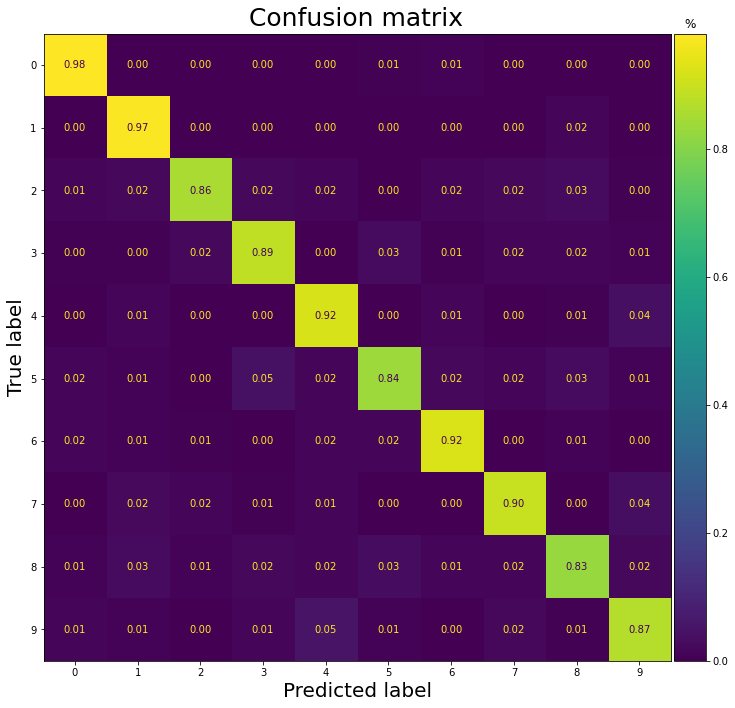

In [36]:
fig, ax = plt.subplots(figsize=(10,10))

plt.xlabel('',fontsize=20)
plt.ylabel('',fontsize=20)

im = metrics.plot_confusion_matrix(X, 
                              A_test, 
                              B_test, 
                              ax=ax, 
                              values_format = '.2f',
                              normalize='true')
im.im_.colorbar.remove()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
clb = plt.colorbar(im.im_, cax=cax)
clb.ax.set_title('%')

plt.suptitle('Confusion matrix', fontsize=25)
plt.tight_layout()
plt.subplots_adjust(top=1)
# plt.savefig('plots/confusion_matrix.png')

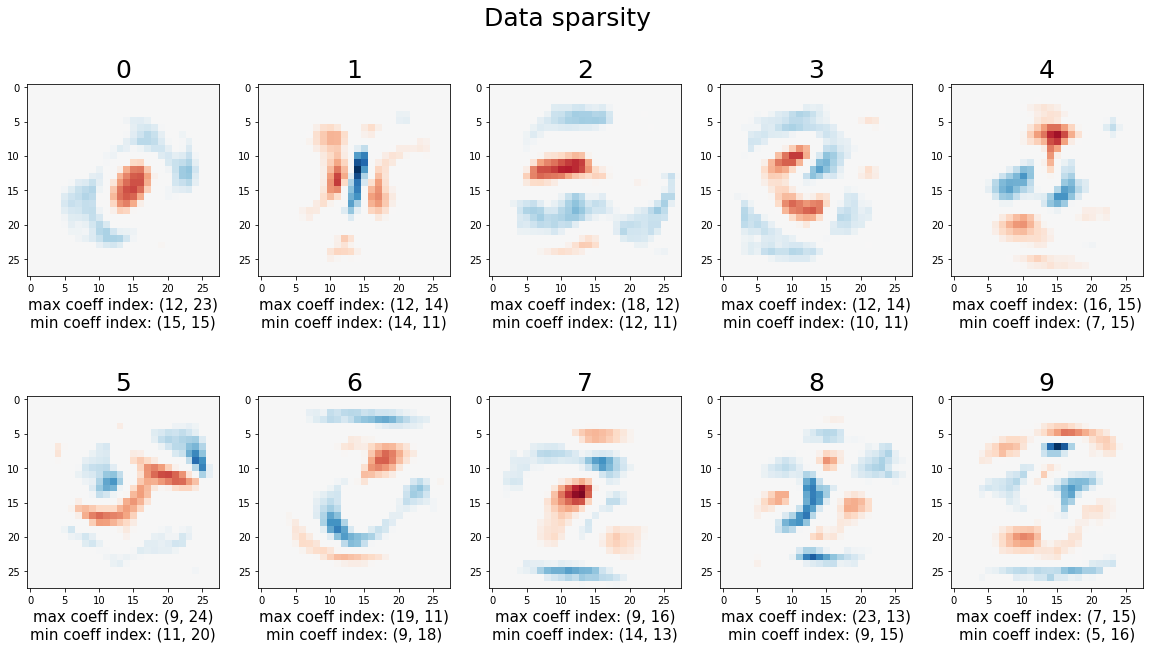

In [37]:
scale = np.abs(coefficients).max()

plt.figure(figsize=(20, 10))

for i in range(len(coefficients)):
    image = coefficients[i].reshape(28, 28).copy()
    
    ax = plt.subplot(2, 5, i + 1)
    ax.imshow(image, 
              interpolation='nearest',
              cmap='RdBu', 
              vmin=-scale, 
              vmax=scale)
    
    max_coeff_index = str(np.unravel_index(image.argmax(), image.shape)) 
    min_coeff_index = str(np.unravel_index(image.argmin(), image.shape)) 
    
    ax.set_title(str(i),fontsize=25)
    
    text = 'max coeff index: ' + max_coeff_index + '\nmin coeff index: ' + min_coeff_index
    ax.set_xlabel(text,fontsize=15)
    
plt.suptitle('Data sparsity', fontsize=25)
plt.subplots_adjust(top=0.92)
# plt.savefig('plots/sparsity.png')

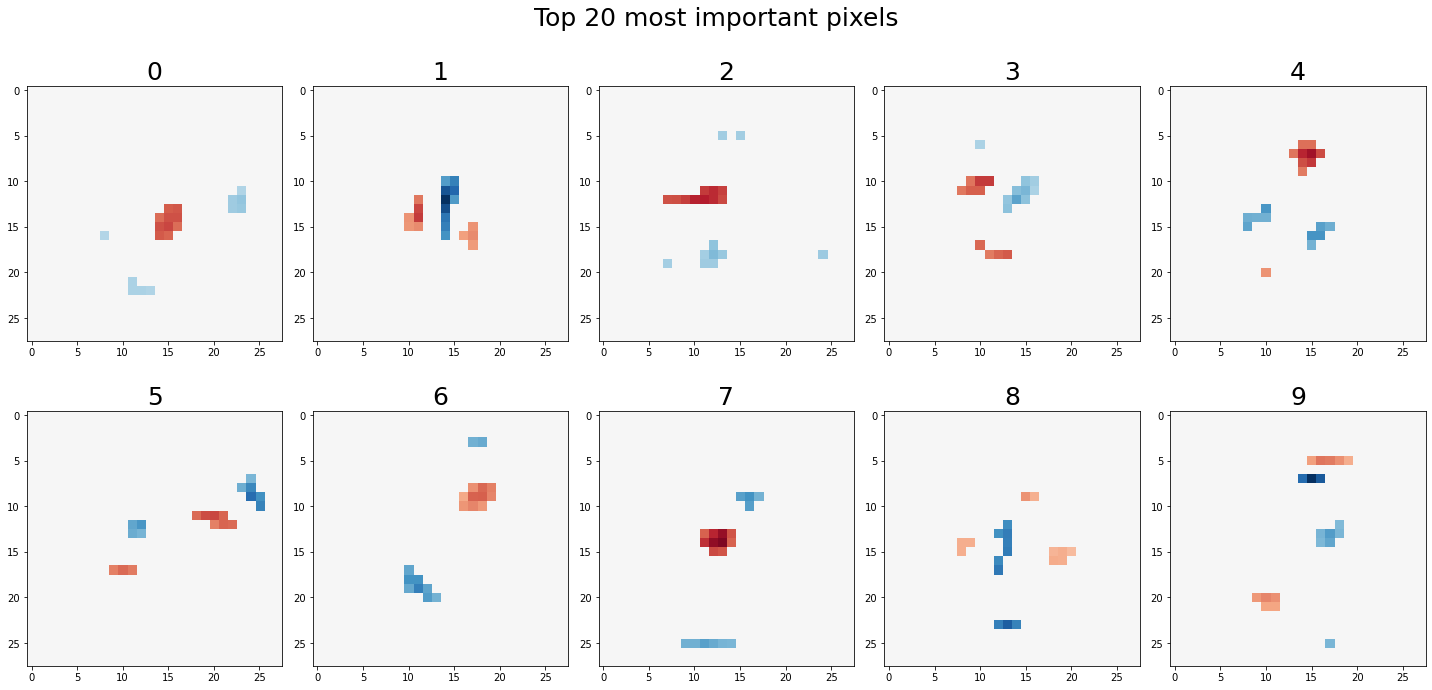

In [38]:
scale = np.abs(coefficients).max()

plt.figure(figsize=(20, 10))

for i in range(len(coefficients)):
    
    img = np.zeros((28,28))
    image = coefficients[i].reshape(28, 28).copy()
    
    for j in range(10):
        max_idx = np.unravel_index(image.argmax(), image.shape)
        min_idx = np.unravel_index(image.argmin(), image.shape)
        
        val = image[max_idx]
        img[max_idx] = val
        image[max_idx] = 0
        
        val = image[min_idx]
        img[min_idx] = val
        image[min_idx] = 0
    
    ax = plt.subplot(2, 5, i + 1)
    ax.imshow(img, 
              interpolation='none',
              cmap='RdBu', 
              vmin=-scale, 
              vmax=scale)
    
    
    ax.set_title(str(i),fontsize=25)
    
    
plt.suptitle('Top 20 most important pixels', fontsize=25)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
# plt.savefig('plots/sparsity_top20.png')

# Data reduction

In [40]:
masked_images = A.copy()

for i in range(10):
    mask = [coefficients[i] == 0]
    
    for index, value in enumerate(labels):
        if value == i:
            masked_images[index][mask] = 0

In [41]:
A = masked_images

In [42]:
X = LogisticRegression(C=0.005, 
                       penalty='l1', 
                       solver='saga', 
                       tol=0.01)

%time X.fit(A, B)

coefficients = X.coef_.copy()
sparsity = np.mean(coefficients == 0) * 100
predictions = X.predict(A_test)
score = X.score(A_test, B_test)

CPU times: user 3min 24s, sys: 155 ms, total: 3min 24s
Wall time: 3min 24s


In [43]:
sparsity

87.04081632653062

In [44]:
score

0.8591

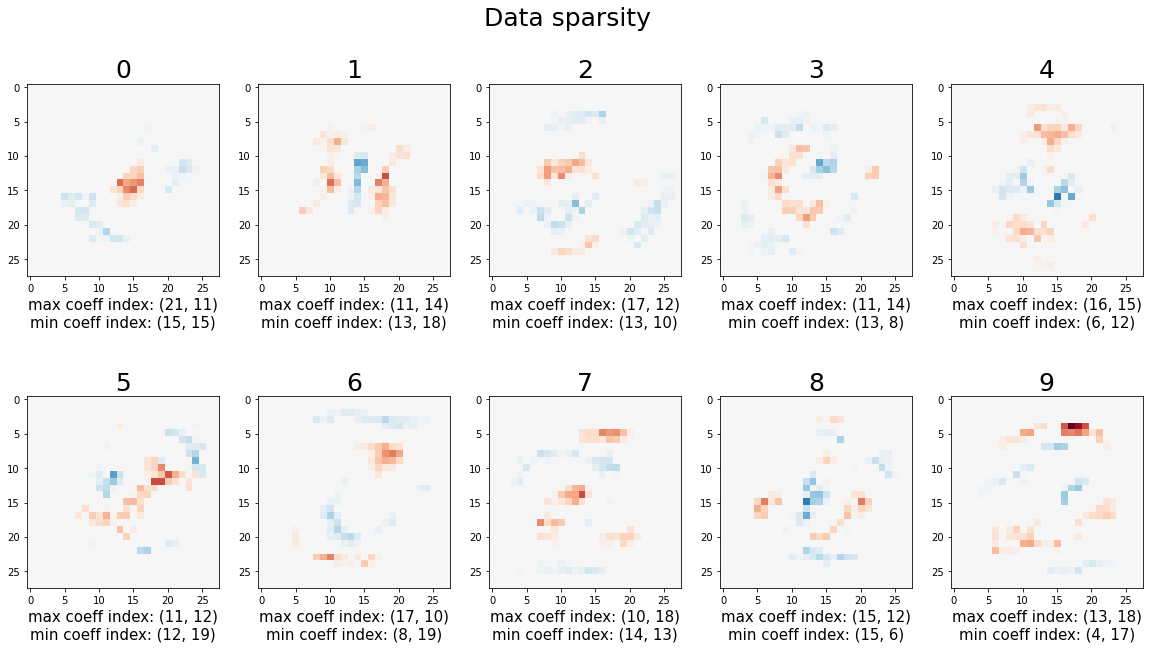

In [45]:
scale = np.abs(coefficients).max()

plt.figure(figsize=(20, 10))

for i in range(len(coefficients)):
    image = coefficients[i].reshape(28, 28).copy()
    
    ax = plt.subplot(2, 5, i + 1)
    ax.imshow(image, 
              interpolation='nearest',
              cmap='RdBu', 
              vmin=-scale, 
              vmax=scale)
    
    max_coeff_index = str(np.unravel_index(image.argmax(), image.shape)) 
    min_coeff_index = str(np.unravel_index(image.argmin(), image.shape)) 
    
    ax.set_title(str(i),fontsize=25)
    
    text = 'max coeff index: ' + max_coeff_index + '\nmin coeff index: ' + min_coeff_index
    ax.set_xlabel(text,fontsize=15)
    
plt.suptitle('Data sparsity', fontsize=25)
plt.subplots_adjust(top=0.92)

In [46]:
import sparse

In [47]:
A = scaler.fit_transform(images)

In [48]:
A[0].nbytes

6272

In [49]:
s = sparse.COO.from_numpy(A[0], fill_value=0)
s1 = s.data.nbytes

In [50]:
s = sparse.COO.from_numpy(masked_images[0], fill_value=0)
s2 = s.data.nbytes

In [51]:
(1 - s2/s1) * 100

70.99023709902372

# Exploring Lasso regression with L1 penalty

In [52]:
mndata = MNIST('./')

images, labels = mndata.load_training()
images = np.array(images)
labels = np.array(labels.tolist())

images_test, labels_test = mndata.load_testing()
images_test = np.array(images_test)
labels_test = np.array(labels_test.tolist())

In [53]:
from sklearn.linear_model import Lasso
# from sklearn.metrics import r2_score

In [54]:
def run_lasso(X_train, y_train, X_test, y_test, alpha):
    lasso = Lasso(alpha=alpha)
    y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
#     r2_score = r2_score(y_test, y_pred_lasso)

    predictions = np.around(y_pred_lasso)
    score = (predictions == y_test).mean()
    
    coefficients = lasso.coef_
    
    sparsity = np.mean(coefficients == 0) * 100
    
    print('Sparsity: ' + str(round(sparsity, 2)) + '\nScore: '+ str(round(score * 100, 2)))
    
    return sparsity, score * 100, coefficients

#### Setup boolean array for each digit

In [55]:
def bool_array(B):
    y = []

    for i in range(10):
        array = []
        for index, value in enumerate(B):
            if value == i:
                array.append(1)
            else:
                array.append(0)


        y.append(array)
        
    y = np.array(y)
    
    return y

#### Test without transforming the data for first digit.

In [56]:
y_train = bool_array(labels)
y_test = bool_array(labels_test)

X_train = images
X_test = images_test

#### Test different lambda values

In [57]:
alphas = [10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
sparsities = []
scores = []
for i in alphas:
    alpha = i
    print('Alpha: ' + str(alpha))
    %time sparsity, score, _ = run_lasso(X_train, y_train[0], X_test, y_test[0], alpha)
    print('\n')
    
    scores.append(score)
    sparsities.append(sparsity)

Alpha: 10
Sparsity: 98.98
Score: 90.2
CPU times: user 4.76 s, sys: 327 ms, total: 5.08 s
Wall time: 1.57 s


Alpha: 5
Sparsity: 96.43
Score: 91.88
CPU times: user 11.7 s, sys: 437 ms, total: 12.1 s
Wall time: 2.33 s


Alpha: 1
Sparsity: 89.16
Score: 97.18
CPU times: user 15.6 s, sys: 382 ms, total: 16 s
Wall time: 2.76 s


Alpha: 0.5
Sparsity: 84.69
Score: 97.53
CPU times: user 19.1 s, sys: 433 ms, total: 19.5 s
Wall time: 3.19 s


Alpha: 0.1
Sparsity: 70.15
Score: 98.12
CPU times: user 25.9 s, sys: 786 ms, total: 26.7 s
Wall time: 4.25 s


Alpha: 0.05
Sparsity: 63.27
Score: 98.2
CPU times: user 24.1 s, sys: 473 ms, total: 24.6 s
Wall time: 3.89 s


Alpha: 0.01
Sparsity: 47.7
Score: 98.4
CPU times: user 40.7 s, sys: 812 ms, total: 41.5 s
Wall time: 6.16 s


Alpha: 0.005
Sparsity: 39.41
Score: 98.42
CPU times: user 1min 1s, sys: 1.05 s, total: 1min 2s
Wall time: 8.9 s


Alpha: 0.001
Sparsity: 26.91
Score: 98.42
CPU times: user 1min 44s, sys: 2.05 s, total: 1min 46s
Wall time: 15.3 s


A

Text(0, 0.5, 'Score (hit %)')

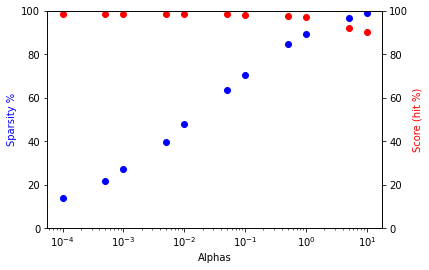

In [58]:
fig, ax1 = plt.subplots()
ax1.scatter(alphas, sparsities, color='b')
ax1.set_xlabel('Alphas')
ax1.set_ylabel('Sparsity %', color='b')

ax1.set_xscale('log')
ax1.set_ylim([0,100])

ax2 = ax1.twinx()
ax2.set_ylim([0,100])

ax2.scatter(alphas, scores, color='r')
ax2.set_ylabel('Score (hit %)', color='r')

*A Lambda (alpha) values of 1 appears to produce the most favorable result with a Sparsity of 89.16 and prediction Score of 97.18*

In [59]:
alpha = 1
lasso = Lasso(alpha=alpha)
y_pred_lasso = lasso.fit(X_train, y_train[0]).predict(X_test)
predictions = np.around(y_pred_lasso)
score = (predictions == y_test[0]).mean()
coefficients = lasso.coef_
sparsity = np.mean(coefficients == 0) * 100

In [60]:
sparsity

89.15816326530613

In [61]:
score

0.9718

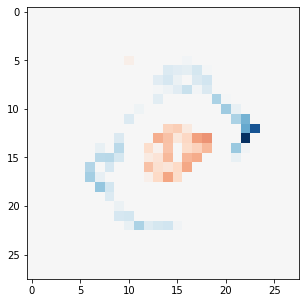

In [62]:
scale = np.abs(coefficients).max()

plt.figure(figsize=(5, 5))

image = coefficients.reshape(28, 28)

ax = plt.subplot()
ax.imshow(image, 
          interpolation='nearest',
          cmap='RdBu', 
          vmin=-scale, 
          vmax=scale)

#### Repeat test with data transformed prior to processing.

In [63]:
scaler = StandardScaler()

X_train = scaler.fit_transform(images)
y_train = bool_array(np.array(labels))

X_test = scaler.transform(images_test)
y_test = bool_array(np.array(labels_test))

In [64]:
alphas = [10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
sparsities = []
scores = []
for i in alphas:
    alpha = i
    print('Alpha: ' + str(alpha))
    %time sparsity, score, _ = run_lasso(X_train, y_train[0], X_test, y_test[0], alpha)
    print('\n')
    
    scores.append(score)
    sparsities.append(sparsity)

Alpha: 10
Sparsity: 100.0
Score: 90.2
CPU times: user 1.75 s, sys: 318 ms, total: 2.07 s
Wall time: 1.38 s


Alpha: 5
Sparsity: 100.0
Score: 90.2
CPU times: user 3.03 s, sys: 339 ms, total: 3.37 s
Wall time: 1.37 s


Alpha: 1
Sparsity: 100.0
Score: 90.2
CPU times: user 3 s, sys: 334 ms, total: 3.33 s
Wall time: 1.32 s


Alpha: 0.5
Sparsity: 100.0
Score: 90.2
CPU times: user 2.85 s, sys: 424 ms, total: 3.28 s
Wall time: 1.36 s


Alpha: 0.1
Sparsity: 99.36
Score: 90.2
CPU times: user 5.91 s, sys: 336 ms, total: 6.24 s
Wall time: 1.65 s


Alpha: 0.05
Sparsity: 96.94
Score: 93.63
CPU times: user 12 s, sys: 533 ms, total: 12.6 s
Wall time: 2.52 s


Alpha: 0.01
Sparsity: 86.99
Score: 97.11
CPU times: user 19.2 s, sys: 493 ms, total: 19.7 s
Wall time: 3.47 s


Alpha: 0.005
Sparsity: 79.34
Score: 97.76
CPU times: user 25.6 s, sys: 687 ms, total: 26.2 s
Wall time: 4.46 s


Alpha: 0.001
Sparsity: 58.29
Score: 98.19
CPU times: user 36.4 s, sys: 965 ms, total: 37.4 s
Wall time: 6.05 s


Alpha: 0.0

Text(0, 0.5, 'Score (hit %)')

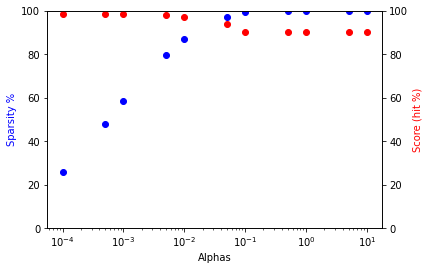

In [65]:
fig, ax1 = plt.subplots()
ax1.scatter(alphas, sparsities, color='b')
ax1.set_xlabel('Alphas')
ax1.set_ylabel('Sparsity %', color='b')

ax1.set_xscale('log')
ax1.set_ylim([0,100])

ax2 = ax1.twinx()
ax2.set_ylim([0,100])

ax2.scatter(alphas, scores, color='r')
ax2.set_ylabel('Score (hit %)', color='r')

*A Lambda (alpha) values of 0.05 appears to produce the most favorable result with a Sparsity of 96.94 and prediction Score of 93.63*

In [66]:
alpha = 0.05
lasso = Lasso(alpha=alpha)
y_pred_lasso = lasso.fit(X_train, y_train[0]).predict(X_test)
predictions = np.around(y_pred_lasso)
score = (predictions == y_test[0]).mean()
coefficients = lasso.coef_
sparsity = np.mean(coefficients == 0) * 100

In [67]:
sparsity

96.93877551020408

In [68]:
score

0.9363

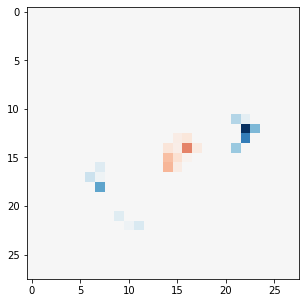

In [69]:
scale = np.abs(coefficients).max()

plt.figure(figsize=(5, 5))

image = coefficients.reshape(28, 28)

ax = plt.subplot()
ax.imshow(image, 
          interpolation='nearest',
          cmap='RdBu', 
          vmin=-scale, 
          vmax=scale)

#### Validate lambda selection with AIC, BIC scores

In [70]:
from sklearn.linear_model import LassoLarsIC

In [71]:
y = y_train[0]
X = X_train

In [72]:
model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(X, y)
alpha_bic = -np.log10(model_bic.alpha_)

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X, y)
alpha_aic = -np.log10(model_aic.alpha_)

In [73]:
alpha_bic, alpha_aic

(4.842288011156222, 5.379637887487564)

*AIC and BIC scores indicate a lambda value of around 5 as being optimal. According to the analysis done above, this would result in a 100% sparse matrix.*

In [74]:
alpha = 5
lasso = Lasso(alpha=alpha)
y_pred_lasso = lasso.fit(X_train, y_train[0]).predict(X_test)
predictions = np.around(y_pred_lasso)
score = (predictions == y_test[0]).mean()
coefficients = lasso.coef_
sparsity = np.mean(coefficients == 0) * 100

In [75]:
sparsity

100.0

In [76]:
score

0.902

*We can see that the coefficients below aren't actually 0, as they have a sign attached. There must be some transformation happening, or loss of precision along the line. My understanding is that a higher lambda value can result in coefficients being rejected, but if they are no longer in the model, it makes it hard to interpret which pixels are playing a role.*

In [77]:
coefficients

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,
       -0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0.,  0.,  0., -0., -0.,  0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -0., -0., -0., -0., -0., -0.,  0.,  0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0., -0., -0., -0.,  0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,  0.,  0

*For this reason, I choose to go with the subjectively derived lambda coefficient value of 0.05, as it still lets me interpret and plot which coefficients and corresponding pixels are most important.*

#### Build model for each digit with transformed data and lambda = 0.05

In [78]:
scores = []
sparsities = []
coefficients = []

for i,v in enumerate(y_train):
    
    print('Digit: ', str(i))
    
    sparsity, score, coeff = run_lasso(X_train, y_train[i], X_test, y_test[i], 0.05)
    
    scores.append(score)
    sparsities.append(sparsity)
    coefficients.append(coeff)
    
    print('\n')

Digit:  0
Sparsity: 96.94
Score: 93.63


Digit:  1
Sparsity: 96.68
Score: 88.65


Digit:  2
Sparsity: 97.32
Score: 90.03


Digit:  3
Sparsity: 97.32
Score: 89.9


Digit:  4
Sparsity: 97.96
Score: 90.18


Digit:  5
Sparsity: 98.85
Score: 91.08


Digit:  6
Sparsity: 97.32
Score: 91.73


Digit:  7
Sparsity: 96.68
Score: 91.01


Digit:  8
Sparsity: 98.72
Score: 90.26


Digit:  9
Sparsity: 97.96
Score: 89.91




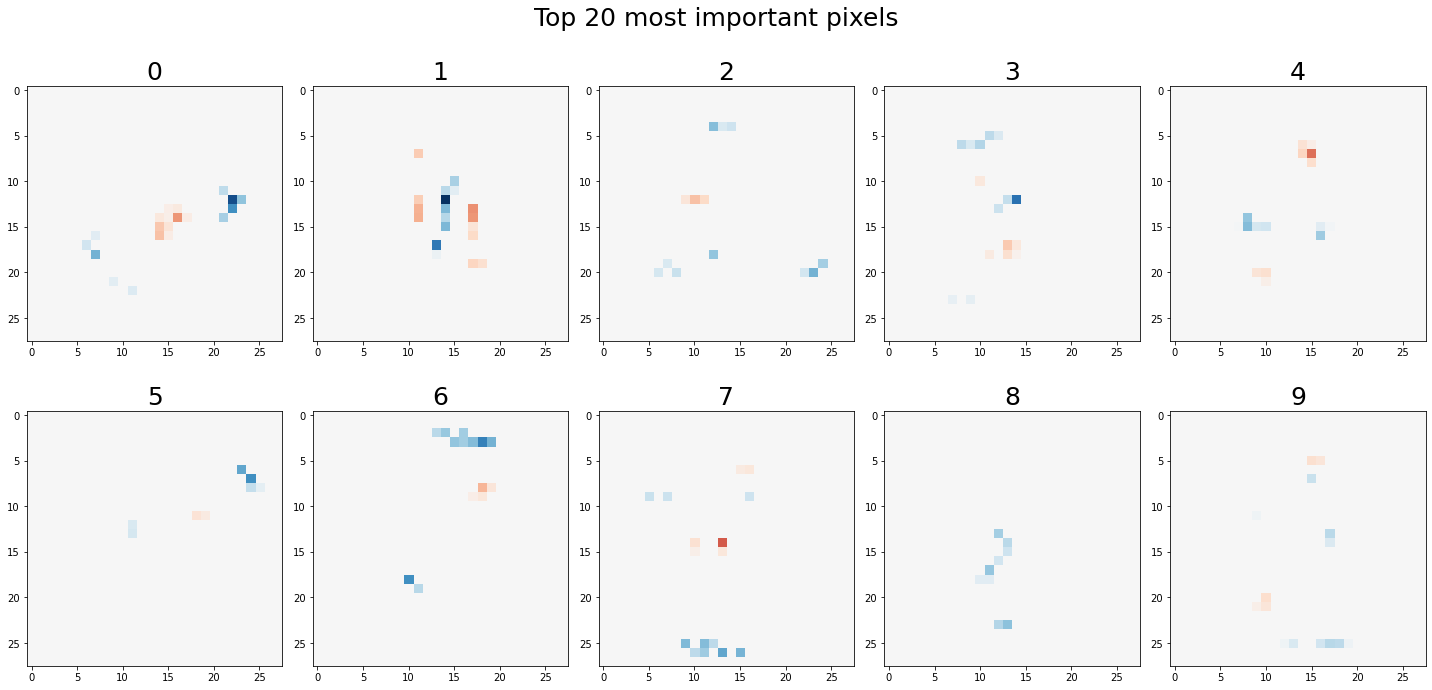

In [79]:
scale = np.abs(coefficients).max()

plt.figure(figsize=(20, 10))

for i in range(len(coefficients)):
    
    img = np.zeros((28,28))
    image = coefficients[i][:].reshape(28, 28).copy()
    
    for j in range(10):
        max_idx = np.unravel_index(image.argmax(), image.shape)
        min_idx = np.unravel_index(image.argmin(), image.shape)
        
        val = image[max_idx]
        img[max_idx] = val
        image[max_idx] = 0
        
        val = image[min_idx]
        img[min_idx] = val
        image[min_idx] = 0
    
    ax = plt.subplot(2, 5, i + 1)
    ax.imshow(img, 
              interpolation='none',
              cmap='RdBu', 
              vmin=-scale, 
              vmax=scale)
    
    
    ax.set_title(str(i),fontsize=25)
    
    
plt.suptitle('Top 20 most important pixels', fontsize=25)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
# plt.savefig('plots/np_sparsity_top20.png')

#### Overall model performance

In [80]:
print('score')
np.array(scores).mean()

score


90.638

In [81]:
print('sparsity')
np.array(sparsities).mean()

sparsity


97.5765306122449